In [6]:
import os
import sys

In [13]:
if not os.path.exists("portfolio-optimizer-notebooks"):
    !git clone https://github.com/Cerebellum-Archive/portfolio-optimizer-notebooks.git

# Install dependencies
verbose=False
if verbose:
    !pip install -r portfolio-optimizer-notebooks/requirements.txt
else:
    !pip install -r portfolio-optimizer-notebooks/requirements.txt > /dev/null 2>&1

# The rest of the imports will now work correctly relative to the project root


Cloning into 'portfolio-optimizer-notebooks'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (33/33), done.
remote: Compressing objects: 100% (24/24), done.
remote: Total 33 (delta 11), reused 25 (delta 6), pack-reused 0 (from 0)
Receiving objects: 100% (33/33), 472.66 KiB | 4.97 MiB/s, done.
Resolving deltas: 100% (11/11), done.


In [7]:
# Get the absolute path of the project root (assuming notebook is in notebooks/ subdirectory)
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))

# Add the project root to Python's module search path if not already there
if project_root not in sys.path:
    sys.path.append(project_root)

In [8]:
# Module Imports
from PortfolioOptimizer import ClassicOptimizer, FactorModelOptimizer
from BW_Optimizer_Simulator import plot_optimizer_performance, create_optimizer_summary_table
from utils_simulate import generate_train_predict_calender
import gcsfs
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [9]:
# Display Settings
pd.set_option('display.notebook_repr_html', True)
%matplotlib inline

---
### Portfolio Risk Management with RiskModels

This notebook demonstrates the use of RiskModels, a portfolio risk tool developed by Blue Water Macro.

We demonstrate how to:

- Construct portfolios using curated return and risk datasets
- Apply multiple risk model frameworks—including historical and multi-factor approaches
- Run flexible optimizations (e.g., Sharpe ratio maximization, minimum variance, and custom constraints)

The included PortfolioOptimizer module is built on top of the powerful [Riskfolio-Lib](https://riskfolio-lib.readthedocs.io/) framework. It simplifies interaction with RiskModels data and streamlines common portfolio construction workflows—offering users a clean, high-level interface without requiring deep familiarity with Riskfolio’s internal configuration.

### Getting Started

The **RiskModels** platform is for portfolio construction and risk management. The examples below use a curated public dataset derived from Blue Water Macro's internal analytics pipeline.

The dataset includes daily equity data for a selected universe of U.S. stocks, enriched with return decompositions, factor exposures, and risk contributions across both **market** and **sector** dimensions.

#### Available Data Fields

Each security is indexed by `ticker` and `date`. The key variables include:

* **Returns**

  * `return`: Total daily return
  * `residual_return`: Return unexplained by market or sector factors
  * `market_factor_return`, `sector_factor_return`: Returns from market and sector ETFs

* **Risk Attribution**

  * `gross_return_variance`: Total variance of returns
  * `market_risk_pct`, `sector_risk_pct`, `residual_risk_pct`: Proportional contribution to risk
  * `market_contr_variance`, `sector_contr_variance`, `residual_variance`: Absolute risk components

* **Factor Exposures (Betas)**

  * `market_beta`, `sector_beta`, `sector_factor_beta`: Sensitivity to market and sector factors
  * `etf_mkt_beta`: Beta relative to a tradable ETF proxy for the market

* **Hedging Signals**

  * `market_hedge_wt`, `sector_hedge_wt`: Suggested hedge weights to neutralize market/sector exposure

* **Classification & Metadata**

  * `bw_sector_code`, `bw_sector_name`: Sector identifiers
  * `sector_etf`: ETF representing the sector
  * `mktcap`: Market capitalization
  * `cross_term_risk_pct`: Interaction term for higher-order risk effects

---

### Data Access and Structure

Blue Water Macro (BWM) distributes its datasets using the **Zarr** format, backed by **Xarray**, enabling efficient, scalable access to high-dimensional labeled data. For this demo, we've stored a representative dataset and made it available via Google Cloud. The PortfolioOptimizer module is designed to work seamlessly with inputs of type xarray.Dataset. Our long-term goal is to support workflows that integrate naturally with xarray—from initial slicing to final portfolio construction.

We'll start by previewing the dataset and demonstrating how to slice it for a specific investment universe and date range. At the end of the notebook, we'll use this dataset to run a backtest and compare the performance of different optimizer configurations. The optimizer operates over all tickers and dates present in the input xarray.Dataset, so it's important to select your target assets and time period in advance.

Let’s begin by downloading and inspecting the data.

In [11]:
rm_demo_ds = xr.load_dataset("../data/rm_demo_ds_20250627.nc")

In [4]:
# Path to the zarr object
zarr_path = 'gs://rm_public_csv/Testing'

In [ ]:
# Lazy load as xarray dataset
rm_demo_ds = xr.open_zarr(zarr_path, storage_options={'token': 'anon'}, consolidated=False)

In [6]:
# Inspect the dataset
rm_demo_ds

<xarray.Dataset> Size: 253kB
Dimensions:                (date: 251, ticker: 10)
Coordinates:
  * date                   (date) datetime64[ns] 2kB 2024-06-27 ... 2025-06-27
  * ticker                 (ticker) object 80B 'NFLX' 'UNH' ... 'PG' 'GOOG'
Data variables: (12/23)
    bw_sector_name         (date, ticker) object 20kB 'Information_Technology...
    sector_etf             (date, ticker) object 20kB 'XLK' 'XLV' ... 'XLK'
    bw_sector_code         (date, ticker) float32 10kB 45.0 35.0 ... 30.0 45.0
    close                  (date, ticker) float32 10kB 684.3 486.4 ... 178.3
    cross_term_risk_pct    (date, ticker) float32 10kB 0.004168 ... 0.002981
    etf_mkt_beta           (date, ticker) float32 10kB 1.309 0.5662 ... 1.282
    ...                     ...
    sector_beta            (date, ticker) float32 10kB 0.6605 1.001 ... 0.6007
    sector_contr_variance  (date, ticker) float32 10kB 0.1228 0.301 ... 0.02648
    sector_factor_beta     (date, ticker) float32 10kB 0.6605 1.001 ... 0.6007
    sector_factor_return   (date, ticker) float32 10kB -0.1578 ... -0.7566
    sector_hedge_wt        (date, ticker) float32 10kB -0.6605 ... -0.6007
    sector_risk_pct        (date, ticker) float32 10kB 0.0258 ... 0.005358

In [5]:
# Store the tickers in this dataset for reference 
tickers = rm_demo_ds['ticker'].values.tolist()
print(tickers)

['NFLX', 'UNH', 'NVDA', 'JNJ', 'AMZN', 'JPM', 'XOM', 'META', 'PG', 'GOOG']


#### Subsetting Data with Xarray

Xarray provides flexible and powerful selection tools for working with labeled N-dimensional arrays. Its API is intuitive—especially for those familiar with pandas—but it does take some adjustment if you're used to seeing your data in tabular format.

In this section, we'll demonstrate some basic subsetting commands that we'll reuse throughout the notebook. These examples should give you a sense of how to work with Xarray's .sel() and indexing functionality.

    💡 Note: One of Xarray's key strengths is how efficiently it handles large datasets without needing to load everything into memory—perfect for financial applications. The tradeoff is that some of the "invisible" behavior, like lazy loading or chunked computations, can be a bit of a learning curve at first.

In [7]:
# Slice by date
rm_demo_ds.sel(date=slice("2025-01-01", "2025-03-31"))

<xarray.Dataset> Size: 61kB
Dimensions:                (date: 60, ticker: 10)
Coordinates:
  * date                   (date) datetime64[ns] 480B 2025-01-02 ... 2025-03-31
  * ticker                 (ticker) object 80B 'NFLX' 'UNH' ... 'PG' 'GOOG'
Data variables: (12/23)
    bw_sector_name         (date, ticker) object 5kB 'Information_Technology'...
    sector_etf             (date, ticker) object 5kB 'XLK' 'XLV' ... 'XLP' 'XLK'
    bw_sector_code         (date, ticker) float32 2kB 45.0 35.0 ... 30.0 45.0
    close                  (date, ticker) float32 2kB 886.7 504.5 ... 156.2
    cross_term_risk_pct    (date, ticker) float32 2kB 0.001425 ... 0.0002577
    etf_mkt_beta           (date, ticker) float32 2kB 1.505 0.4684 ... 1.518
    ...                     ...
    sector_beta            (date, ticker) float32 2kB 0.1865 1.506 ... 0.02588
    sector_contr_variance  (date, ticker) float32 2kB 0.1047 0.3208 ... 0.02745
    sector_factor_beta     (date, ticker) float32 2kB 0.1865 1.506 ... 0.02588
    sector_factor_return   (date, ticker) float32 2kB 0.1333 0.1442 ... -0.9706
    sector_hedge_wt        (date, ticker) float32 2kB -0.1865 ... -0.02588
    sector_risk_pct        (date, ticker) float32 2kB 0.02959 ... 0.008813

In [8]:
# Slice by ticker
rm_demo_ds.sel(ticker=["AMZN", "GOOG"])

<xarray.Dataset> Size: 52kB
Dimensions:                (date: 251, ticker: 2)
Coordinates:
  * date                   (date) datetime64[ns] 2kB 2024-06-27 ... 2025-06-27
  * ticker                 (ticker) object 16B 'AMZN' 'GOOG'
Data variables: (12/23)
    bw_sector_name         (date, ticker) object 4kB 'Consumer_Discretionary'...
    sector_etf             (date, ticker) object 4kB 'XLY' 'XLK' ... 'XLY' 'XLK'
    bw_sector_code         (date, ticker) float32 2kB 25.0 45.0 ... 25.0 45.0
    close                  (date, ticker) float32 2kB 197.9 186.9 ... 178.3
    cross_term_risk_pct    (date, ticker) float32 2kB 0.002406 ... 0.002981
    etf_mkt_beta           (date, ticker) float32 2kB 1.175 1.309 ... 1.282
    ...                     ...
    sector_beta            (date, ticker) float32 2kB 0.1958 0.4228 ... 0.6007
    sector_contr_variance  (date, ticker) float32 2kB 0.3588 0.07605 ... 0.02648
    sector_factor_beta     (date, ticker) float32 2kB 0.1958 0.4228 ... 0.6007
    sector_factor_return   (date, ticker) float32 2kB 0.4255 -0.1578 ... -0.7566
    sector_hedge_wt        (date, ticker) float32 2kB -0.1958 ... -0.6007
    sector_risk_pct        (date, ticker) float32 2kB 0.1131 ... 0.005358

In [9]:
# Subset by date range and ticker
rm_demo_ds.sel(date=slice("2025-01-01","2025-03-31"), ticker=["GOOG","NVDA"])

<xarray.Dataset> Size: 12kB
Dimensions:                (date: 60, ticker: 2)
Coordinates:
  * date                   (date) datetime64[ns] 480B 2025-01-02 ... 2025-03-31
  * ticker                 (ticker) object 16B 'GOOG' 'NVDA'
Data variables: (12/23)
    bw_sector_name         (date, ticker) object 960B 'Information_Technology...
    sector_etf             (date, ticker) object 960B 'XLK' 'XLK' ... 'XLK'
    bw_sector_code         (date, ticker) float32 480B 45.0 45.0 ... 45.0 45.0
    close                  (date, ticker) float32 480B 190.6 138.3 ... 108.4
    cross_term_risk_pct    (date, ticker) float32 480B -0.001801 ... 0.01551
    etf_mkt_beta           (date, ticker) float32 480B 1.505 1.505 ... 1.518
    ...                     ...
    sector_beta            (date, ticker) float32 480B -0.1803 2.505 ... 2.699
    sector_contr_variance  (date, ticker) float32 480B 0.0474 1.911 ... 2.452
    sector_factor_beta     (date, ticker) float32 480B -0.1803 2.505 ... 2.699
    sector_factor_return   (date, ticker) float32 480B 0.1333 0.1333 ... -0.9706
    sector_hedge_wt        (date, ticker) float32 480B 0.1803 -2.505 ... -2.699
    sector_risk_pct        (date, ticker) float32 480B 0.01616 0.1895 ... 0.215

---
### Portfolio Construction: Classic Optimization

The `ClassicOptimizer` class provides a streamlined interface for building portfolios using **historical return data**. It wraps Riskfolio-Lib’s `Portfolio` object while adding safeguards to validate configuration, provide defaults, and enforce consistency.

In the following example, we use the optimizer to **maximize the Sharpe Ratio** based on `residual_return`, focusing the portfolio on stock-specific performance. This simulates a **market- and sector-neutral portfolio**, a useful configuration for exploring alpha generation using factor-aware data. The expected returns vector (μ) and covariance matrix (Σ) are estimated from historical residual returns using **exponentially weighted moving averages (EWMA)**.

> ⚠️ **Caution**: Riskfolio’s configuration system is quite intricate. It’s easy to think you've set a parameter one way, only to have it silently overridden by another setting or method call. Be especially mindful of interactions between `model`, `method_mu`, `method_cov`, and `rm`.

```python
classic_mvo = ClassicOptimizer(
    train_ds,
    optimizer_config={
        "model": "Classic",               # Use the classic Markowitz model
        "rm": "MV",                       # Mean-variance as the risk measure
        "rf": 0,                          # Risk-free rate
        "l": 0,                           # Risk aversion parameter (not used here)
        "method_mu": "ewma",             # Estimate expected returns via EWMA
        "method_cov": "ewma",            # Estimate covariance matrix via EWMA
        "halflife": 30,                  # EWMA decay factor in trading days
        "hist": False,                   # Use factor-based returns, not raw historical
        "obj": "Sharpe",                 # Objective: maximize Sharpe ratio
        "sht": True,                     # Allow short positions
        "budget": 1.0,                   # Full investment (weights sum to 1)
        "uppersht": 1.0,                 # Max absolute short exposure
        "upperlng": 1.0,                 # Max long exposure
        "returns_var": "residual_return",# Use stock-specific residual returns
        "mu_scalar": None                # No scalar applied to expected returns
    }
)
```

In [5]:
# Create the ClassicOptimizer instance
classic_mvo = ClassicOptimizer(
    rm_demo_ds,
    optimizer_config={
        "model": "Classic",              # Use the classic Markowitz model
        "rm": "MV",                      # Mean-variance as the risk measure
        "rf": 0,                         # Risk-free rate
        "l": 0,                          # Risk aversion parameter (not used here)
        "method_mu": "hist",             # Estimate expected returns via EWMA
        "method_cov": "hist",            # Estimate covariance matrix via EWMA
        "hist": True,                    # Use factor-based returns, not raw historical
        "obj": "Sharpe",                 # Objective: maximize Sharpe ratio
        "sht": False,                    # Allow short positions
        "budget": 1.0,                   # Full investment (weights sum to 1)
        "uppersht": 1.0,                 # Max absolute short exposure
        "upperlng": 1.0,                 # Max long exposure
        "returns_var": "residual_return",# Use stock-specific residual returns
        "mu_scalar": None                # No scalar applied to expected returns
    }
)

In [7]:
# Optimize wegihts on residual returns
classic_mvo.fit()

In [8]:
classic_mvo.weights_

,weights
AMZN,2.111376e-09
GOOG,1.855686e-10
JNJ,3.300393e-01
JPM,1.823025e-01
META,8.967150e-02
NFLX,2.107519e-01
NVDA,8.091175e-02
PG,1.171294e-09
UNH,7.156242e-03
XOM,9.916675e-02


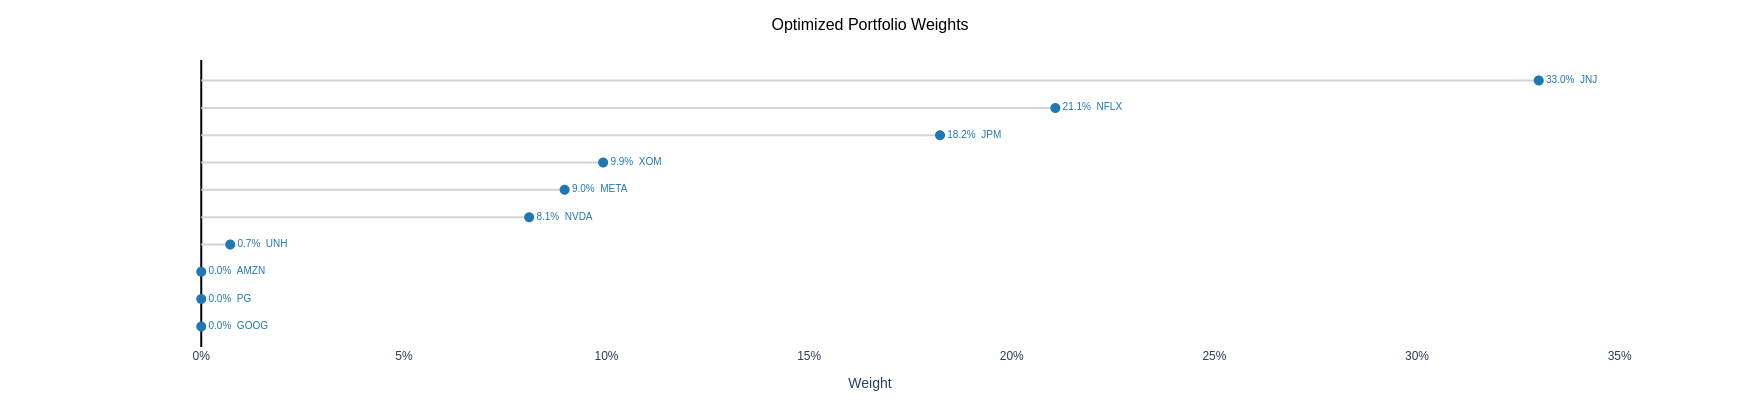

In [9]:
# Visualize optimalized weights 
classic_mvo.plot_weights_plotly()

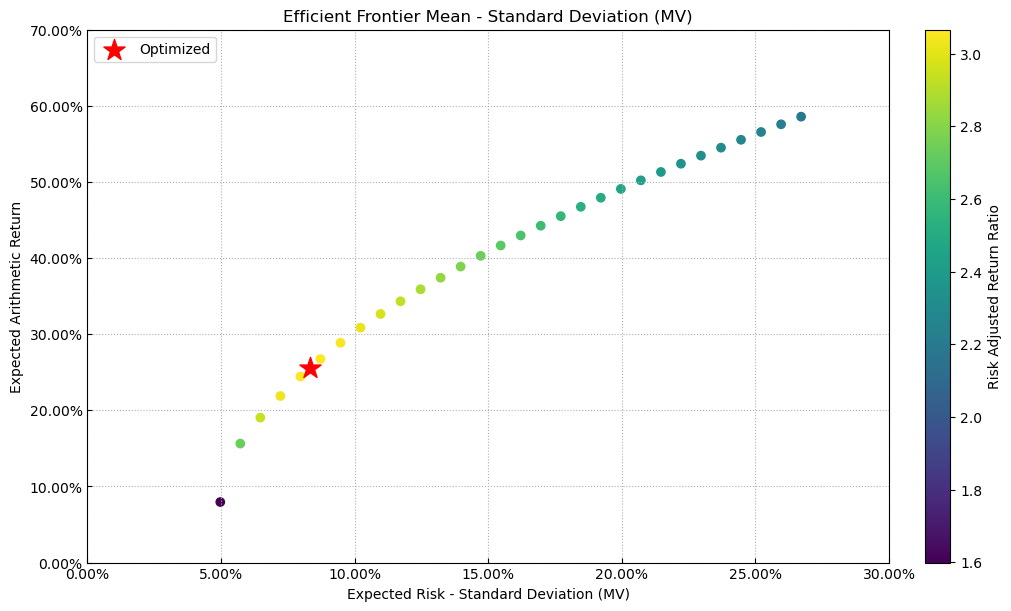

In [10]:
# Visualize the efficient frontier 
classic_mvo.plot_frontier()

---

### Portfolio Construction: Factor Model Optimization

The `FactorModelOptimizer` class enables portfolio optimization using a **linear factor model**, where both the expected returns (**μ**) and the covariance matrix (**Σ**) are explicitly constructed using **RiskModels factor data**. This class is ideal for users who want to take full advantage of the structured risk decomposition offered by Blue Water Macro’s equity models.

#### **Covariance Matrix: Classic vs Factor Model**

One of the most important distinctions between the **Classic** and **Factor Model** optimizers lies in how they estimate the **covariance matrix** of asset returns — the core input to most portfolio optimizations.

> In the ClassicOptimizer example above, we chose to compute the covariance matrix in **residual return space**, where factor effects are removed. In larger portfolios with many assets, there remains a chance that erroneous correlations will still arise due to noise in the residuals.

> In contrast, the **factor model** projects asset returns onto a smaller number of common risk factors, dramatically reducing the dimensionality of the covariance estimation. This helps to filter out noise, stabilize estimates, and improve out-of-sample robustness—especially when the number of assets is large relative to the lookback period.

**Classic Optimizer**:
  - Uses a full **n × n sample covariance matrix**, where _n_ is the number of assets.
  - Captures pairwise relationships between assets directly.
  - Can be **noisy and is susceptible to overfitting**, especially with limited historical data.

**Factor Model Optimizer**:
  - Uses a **structured covariance matrix** built from:
    - Factor exposures (`β`)
    - Factor return covariances (`F`)
    - Residual (idiosyncratic) variances (`D`)
  - Often lower-dimensional and more stable.
  - Helps **reduce estimation error** and improve **out-of-sample robustness**.

By using fewer inputs and focusing on systematic risk, the factor-based approach can produce more **parsimonious, interpretable**, and potentially **more stable** portfolios.

> ⚠️ **Note**: Although Riskfolio-Lib includes its own internal support for factor models, `FactorModelOptimizer` bypasses that functionality. Instead, it directly constructs the inputs (`μ` and `Σ`) from pre-calculated factor exposures, returns, and residual variances in the input dataset. This is more flexible and accurate when using institutional-grade risk model inputs.

#### **Constructing the Covariance Matrix and Expected Returns**

The `FactorModelOptimizer` class constructs the expected returns vector (**μ**) and covariance matrix (**Σ**) using the `compute_mu_sigma()` method, leveraging factor-based inputs from the Blue Water Macro datasets.

This process involves following steps:

1. Builds the factor exposure matrix **B** using the end-of-window data.
2. Computes the factor covariance matrix **F** (configurable: 'hist' (mean), 'ewma')
3. Estimates the factor returns **f** (configurable: 'hist' (mean), 'ewma', 'scaled_f').
4. Assembles the diagonal residual variance matrix **D**
5. Computes:

>Expected returns:    **μ = B · f**  
Covariance matrix:   **Σ = B · F · Bᵗ + D**

---

In [11]:
# Create the FactorModelOptimizer instance
factor_model = FactorModelOptimizer(rm_demo_ds,
                                    optimizer_config={
                                    "model": "Classic",          # Classic Markowitz optimizer
                                    "rm": "MV",                  # Risk Measure: MV = mean variance
                                    "rf": 0,                     # Risk-free rate (in decimal form)
                                    "l": 0,                      # Risk aversion (used in some models)
                                    "method_f": "ewma",          # Method to estimate expected returns
                                    "method_F": "ewma",          # Method to estimate covariance matrix
                                    "halflife": 30,              # EWMA halflife in trading days
                                    "hist": False,               # sigma & mu are computed from factor data
                                    "obj": "Sharpe",             # Optimization objective
                                    "sht": True,                 # Allow shorts
                                    "budget": 1.0,               # Absolute sum of weights
                                    "uppersht": 1.0,             # Maximum sum of absolute values of short
                                    "upperlng": 1.0,             # Maximum of the sum of long
                                    "returns_var": "return",     # Returns variable name: 'return' or 'residual_return'
                                    "f_scalar": None             # Scalar applied to expected factor returns [0,1]
                                    }
                                   )

Let's go ahead and compute μ and Σ and inspect the conponents.

In [12]:
# Construct the covariance matrix sigma
factor_model.compute_mu_sigma()

In [13]:
# Inspect the exposure matrix B
factor_model.B

,market_beta,Consumer_Discretionary,Consumer_Staples,Energy,Financials,Health_Care,Information_Technology
ticker,,,,,,,
AMZN,1.279137,0.922753,0.000000,0.000000,0.000000,0.000000,0.000000
GOOG,1.004298,0.000000,0.000000,0.000000,0.000000,0.000000,0.600650
JNJ,0.060335,0.000000,0.000000,0.000000,0.000000,1.011271,0.000000
JPM,0.880639,0.000000,0.000000,0.000000,1.070058,0.000000,0.000000
META,1.407166,0.000000,0.000000,0.000000,0.000000,0.000000,0.530078
NFLX,0.851564,0.000000,0.000000,0.000000,0.000000,0.000000,0.514257
NVDA,1.735625,0.000000,0.000000,0.000000,0.000000,0.000000,2.960326
PG,0.229182,0.000000,1.117728,0.000000,0.000000,0.000000,0.000000
UNH,0.074634,0.000000,0.000000,0.000000,0.000000,0.946002,0.000000


In [14]:
# Inspect the expected factor returns
factor_model.f

,f
Market,0.001507
Consumer_Discretionary,-0.000439
Consumer_Staples,-0.000447
Energy,-0.000773
Financials,-0.000082
Health_Care,-0.001069
Information_Technology,0.000640


In [15]:
# Inspect the expected factor covariance matrix
factor_model.F

Market  Consumer_Discretionary  \
date                                                                  
2025-06-27 Market                  0.000217               -0.000037   
           Consumer_Discretionary -0.000037                0.000060   
           Consumer_Staples        0.000011               -0.000003   
           Energy                  0.000046               -0.000026   
           Financials              0.000011               -0.000004   
           Health_Care             0.000036               -0.000019   
           Information_Technology -0.000036                0.000002   

                                   Consumer_Staples        Energy  Financials  \
date                                                                            
2025-06-27 Market                      1.118657e-05  4.627050e-05    0.000011   
           Consumer_Discretionary     -2.988186e-06 -2.638798e-05   -0.000004   
           Consumer_Staples            6.837510e-05  7.143277e-07    0.000019   
           Energy                      7.143277e-07  1.948376e-04    0.000007   
           Financials                  1.868386e-05  6.877441e-06    0.000033   
           Health_Care                 3.582745e-05  7.369994e-06    0.000012   
           Information_Technology     -3.005366e-05 -2.433634e-05   -0.000015   

                                   Health_Care  Information_Technology  
date                                                                    
2025-06-27 Market                     0.000036               -0.000036  
           Consumer_Discretionary    -0.000019                0.000002  
           Consumer_Staples           0.000036               -0.000030  
           Energy                     0.000007               -0.000024  
           Financials                 0.000012               -0.000015  
           Health_Care                0.000086               -0.000027  
           Information_Technology    -0.000027                0.000034

In [16]:
# Inspect the residual variance matrix
factor_model.D

ticker,AMZN,GOOG,JNJ,JPM,META,NFLX,NVDA,PG,UNH,XOM
ticker,,,,,,,,,,
AMZN,0.015546,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
GOOG,0.000000,0.02351,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
JNJ,0.000000,0.00000,0.008192,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
JPM,0.000000,0.00000,0.000000,0.007181,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
META,0.000000,0.00000,0.000000,0.000000,0.024025,0.000000,0.000000,0.000000,0.000000,0.000000
NFLX,0.000000,0.00000,0.000000,0.000000,0.000000,0.028103,0.000000,0.000000,0.000000,0.000000
NVDA,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.023476,0.000000,0.000000,0.000000
PG,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.005766,0.000000,0.000000
UNH,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.066993,0.000000


In [17]:
# Inspect the full covariance matrix
factor_model.sigma_

ticker,AMZN,GOOG,JNJ,JPM,META,NFLX,NVDA,PG,UNH,XOM
ticker,,,,,,,,,,
AMZN,0.015865,0.000218,4.313764e-05,0.000226,0.000319,0.000184,2.912264e-04,0.000069,0.000045,0.000155
GOOG,0.000218,0.023697,3.232663e-05,0.000175,0.000268,0.000159,2.936170e-04,0.000037,0.000034,0.000129
JNJ,0.000043,0.000032,8.285373e-03,0.000058,0.000054,0.000027,1.726791e-07,0.000053,0.000088,0.000035
JPM,0.000226,0.000175,5.780425e-05,0.007409,0.000260,0.000148,2.098738e-04,0.000080,0.000058,0.000148
META,0.000319,0.000268,5.431990e-05,0.000260,0.024410,0.000227,3.997456e-04,0.000065,0.000056,0.000194
NFLX,0.000184,0.000159,2.726685e-05,0.000148,0.000227,0.028237,2.491490e-04,0.000031,0.000029,0.000109
NVDA,0.000291,0.000294,1.726791e-07,0.000210,0.000400,0.000249,2.405522e-02,-0.000016,0.000005,0.000142
PG,0.000069,0.000037,5.259936e-05,0.000080,0.000065,0.000031,-1.586532e-05,0.005868,0.000050,0.000042
UNH,0.000045,0.000034,8.835523e-05,0.000058,0.000056,0.000029,5.073392e-06,0.000050,0.067076,0.000035


Finally, let's optimize across the entire window and calculate the in-sample Sharpe ratio.

In [18]:
factor_model.fit()

In [19]:
factor_model.weights_

,weights
AMZN,1.630057e-01
GOOG,1.388415e-01
JNJ,-1.803846e-01
JPM,2.898456e-01
META,1.740470e-01
NFLX,9.901486e-02
NVDA,3.352453e-01
PG,-4.180484e-08
UNH,-1.961523e-02
XOM,8.811089e-10


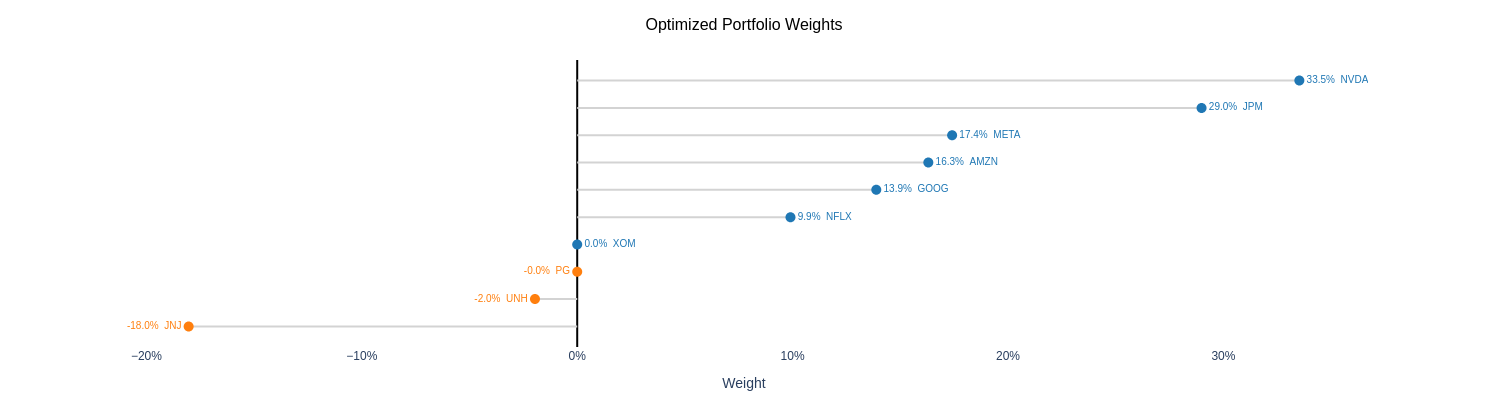

In [20]:
# Visualize optimalized weights 
factor_model.plot_weights_plotly()

In [21]:
# The in-sample mu calcuated using 'ewma' with the halflife=30
factor_model.mu_

ticker
AMZN    0.001523
GOOG    0.001898
JNJ    -0.000990
JPM     0.001240
META    0.002460
NFLX    0.001613
NVDA    0.004510
PG     -0.000155
UNH    -0.000899
XOM    -0.000024
dtype: float64

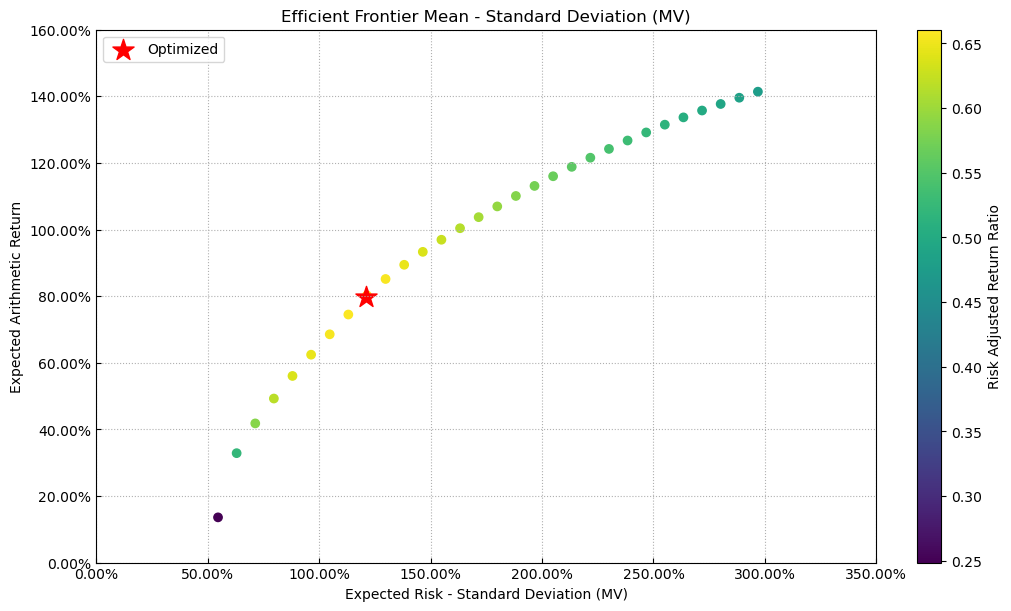

In [22]:
# Visualize the efficient frontier 
factor_model.plot_frontier()

---

## Rolling Backtest: Classic vs Factor Model Optimizers

In this section, we compare the performance of two portfolio optimization strategies using a rolling backtest:

1. **Classic Optimizer**  
   A traditional Markowitz-style optimizer that directly uses **gross returns** to estimate expected returns (`mu`) and the covariance matrix (`sigma`). It optimizes weights to maximize the Sharpe ratio.

2. **Factor Model Optimizer**  
   A risk model–based optimizer that constructs expected returns and risk using a **factor structure**. The model separates systematic risk (via factors like market and sector) from idiosyncratic (residual) risk. It then uses these inputs to optimize the portfolio under the same objective.

### Shared Backtest Configuration

- **Estimation Method**: Both models use **exponentially weighted moving averages (EWMA)** with a **30-day half-life** to estimate expected returns and covariance.
- **Rebalancing Frequency**: Daily. On each date, optimized weights are recalculated and applied to the next day’s returns.
- **Realized Portfolio Returns**: Calculated by applying the optimized weights from the training window to the **next day’s asset returns**.
- **Benchmark Portfolio**: An **equal-weighted portfolio**, where each stock in the universe is given the same weight, serves as the benchmark for performance comparison.

### Rolling Window Details

- **Window Type**: **Expanding**. The training window starts at 60 trading days and grows over time as we move forward through the backtest.
- **Window Size**: The backtest begins on the **60th trading day** of the dataset to ensure a sufficient estimation window.
- **Dataset Duration**: The dataset includes one year of daily price and return history.

This setup provides a consistent framework to compare the in-sample optimization and out-of-sample performance of both strategies under realistic, rolling conditions.

---

Let's set up the simulation and inspect the date range calendar.

In [23]:
# Get datetime index from dataset
dummy_df = pd.DataFrame(index=pd.to_datetime(rm_demo_ds.coords['date'].values))
dummy_df.index.name = 'date'

# Generate train/predict date ranges
date_ranges = generate_train_predict_calender(
    df=dummy_df,
    window_type='expanding',  # or 'fixed'
    window_size=60            # lookback window
)

In [24]:
print(f" First date range: {date_ranges[0]}\n Last date range {date_ranges[-1]}")

 First date range: [Timestamp('2024-06-27 00:00:00'), Timestamp('2024-09-20 00:00:00'), Timestamp('2024-09-23 00:00:00')]
 Last date range [Timestamp('2024-06-27 00:00:00'), Timestamp('2025-06-26 00:00:00'), Timestamp('2025-06-27 00:00:00')]


In [25]:
# Run rolling optimization and prediction
classic_opt_results = []
factor_opt_results = []

for train_start, train_end, pred_date in date_ranges:
    # Slice in-sample data
    train_ds = rm_demo_ds.sel(date=slice(train_start, train_end))

    # Slice next-day returns for prediction (single row)
    next_day = rm_demo_ds.sel(date=pred_date)

    # Calculate equal-weighted portfolio
    next_day_ret = next_day['return'].to_series()*0.01
    next_day_ret.index.name = 'ticker'
    benchmark_ret = next_day_ret.mean().item()


    # Initialize ClassicOptimizer and optimize over gross returns
    classic_opt = ClassicOptimizer(
        train_ds,
        optimizer_config={
            "model": "Classic",               # Classic Markowitz optimizer
            "rm": "MV",                       # Risk Measure: MV = mean variance
            "rf": 0,                          # Risk-free rate (in decimal form)
            "l": 0,                           # Risk aversion (used in some models)
            "method_mu": "ewma",              # Method to estimate expected returns
            "method_cov": "ewma",             # Method to estimate covariance matrix
            "halflife": 30,                   # EWMA halflife in trading days
            "hist": False,                    # sigma & mu are computed from factor data
            "obj": "Sharpe",                  # Optimization objective
            "sht": True,                      # Allow shorts
            "budget": 1.0,                    # Absolute sum of weights
            "uppersht": 1.0,                  # Maximum sum of absolute values of short
            "upperlng": 1.0,                  # Maximum of the sum of long
            "returns_var": "return",          # Returns variable name: 'return' or 'residual_return'
            "mu_scalar": None                 # Scalar applied to expected returns [0,1]
        }
    )

    # Initialize FactorModelOptimizer and optimize
    factor_opt = FactorModelOptimizer(
        train_ds,
        optimizer_config={
            "model": "Classic",          # Classic Markowitz optimizer
            "rm": "MV",                  # Risk Measure: MV = mean variance
            "rf": 0,                     # Risk-free rate (in decimal form)
            "l": 0,                      # Risk aversion (used in some models)
            "method_f": "ewma",          # Method to estimate expected returns
            "method_F": "ewma",          # Method to estimate covariance matrix
            "halflife": 30,              # EWMA halflife in trading days
            "hist": False,               # sigma & mu are computed from factor data
            "obj": "Sharpe",             # Optimization objective
            "sht": True,                 # Allow shorts
            "budget": 1.0,               # Absolute sum of weights
            "uppersht": 1.0,             # Maximum sum of absolute values of short
            "upperlng": 1.0,             # Maximum of the sum of long
            "returns_var": "return",     # Returns variable name: 'return' or 'residual_return'
            "f_scalar": None             # Scalar applied to expected factor returns [0,1]
        }
    )

    # Optimize over the training dataset
    classic_opt.fit()
    factor_opt.fit()

    # Realized next-day portfolio return
    classic_pred_ret = classic_opt.predict(next_day)
    factor_pred_ret = factor_opt.predict(next_day)

    # Store results
    classic_opt_results.append({
        'prediction_date': pred_date,
        'portfolio_ret': classic_pred_ret,
        'benchmark_ret': benchmark_ret,
        'weights': classic_opt.weights_,
        'leverage': classic_opt.weights_.sum().item(),
        'mu_': classic_opt.mu_,
        'ret_': classic_opt.port_return_,
        'vol_': classic_opt.port_vol_,
        'sharpe_': classic_opt.sharpe_,
    })

    factor_opt_results.append({
        'prediction_date': pred_date,
        'portfolio_ret': factor_pred_ret,
        'benchmark_ret': benchmark_ret,
        'weights': factor_opt.weights_,
        'leverage': factor_opt.weights_.sum().item(),
        'mu_': factor_opt.mu_,
        'ret_': factor_opt.port_return_,
        'vol_': factor_opt.port_vol_,
        'sharpe_': factor_opt.sharpe_,
    })

# Combine the results
results_dict = {'Classic': classic_opt_results, 'FactorModel': factor_opt_results}

Now that we have our results, let's generate some plots to visualize the performance.

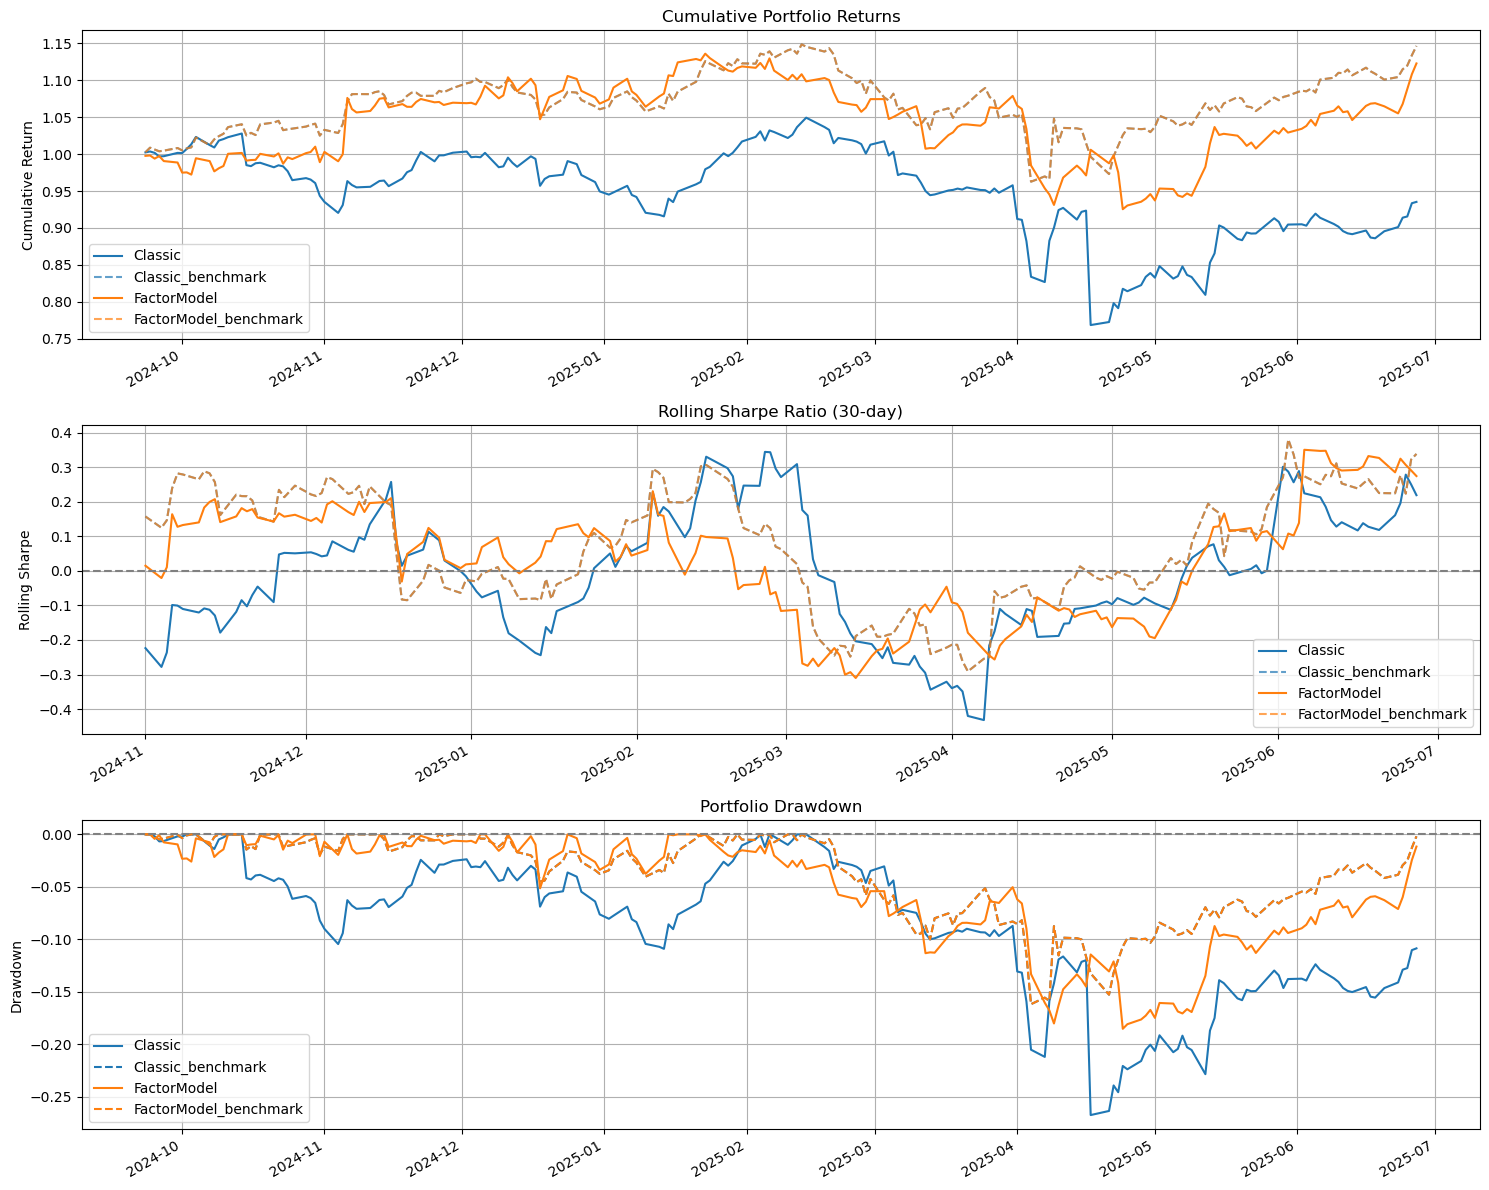

In [26]:
plot_optimizer_performance(results_dict, rolling_window=30, save_plt=False)

Let's also generate a summary table describing the portfolios.

In [27]:
summary_df = create_optimizer_summary_table(results_dict, save_csv=False)
summary_df

,Strategy,Portfolio_Annual_Return,Portfolio_Annual_Vol,Portfolio_Sharpe,Portfolio_Max_DD,Benchmark_Annual_Return,Benchmark_Annual_Vol,Benchmark_Sharpe,Benchmark_Max_DD,Excess_Return,Sharpe_Improvement
0,Classic,-0.041336,0.299611,-0.137966,-0.287729,0.199066,0.195445,1.018528,-0.172062,-0.240402,-1.156494
1,FactorModel,0.177503,0.223927,0.792683,-0.197094,0.199066,0.195445,1.018528,-0.172062,-0.021563,-0.225845


### **Conclusion: Strategy Comparison**

The rolling backtest results reveal a stark contrast between the two optimization approaches:

- The **Classic Optimizer** underperformed significantly, yielding a **negative annual return of -4.13%** and a **Sharpe ratio of -0.14**, compared to the equal-weighted benchmark’s **Sharpe of 1.02**. This strategy also experienced the **largest drawdown (-28.8%)**, highlighting its vulnerability to market volatility — particularly during the sharp losses observed in **April 2025**.
  
- The **Factor Model Optimizer**, by contrast, delivered a **positive annual return of 17.75%** with a **Sharpe ratio of 0.79**. While it slightly underperformed the benchmark on a risk-adjusted basis (Sharpe improvement of -0.23), its **maximum drawdown was notably smaller (-19.7%)**, and it **tracked the benchmark more closely** over the full period.

These results illustrate that while the classic approach can be unstable in small samples, the factor-based method provides more **stable and resilient** performance, even when its risk-adjusted returns are not significantly better than a naive benchmark.

---

### Concluding Remarks

We hope this notebook has provided a useful introduction to portfolio construction using **RiskModels datasets**. By integrating high-quality return and risk data from Blue Water Macro with flexible optimization tools, you can explore a range of investment strategies — from traditional mean-variance optimization to more sophisticated factor-aware approaches.

The example workflows shown here are just the beginning. The [PortfolioOptimizer](https://github.com/drewtilley/portfolio-optimizer-notebooks) framework is designed to be modular and extensible, and the dataset is intended to make advanced risk models more accessible to analysts, researchers, and asset managers.

This repository is public and intended as a living demo — contributions, suggestions, and questions are welcome. If you have feedback or ideas for additional functionality, factor models, or optimization objectives, please [open an issue](https://github.com/drewtilley/portfolio-optimizer-notebooks/issues) or contact us directly.

> 📬 For questions about using RiskModels data in your own workflows — including access to full datasets — feel free to reach out to [support@riskmodels.net](mailto:support@riskmodels.net).

Thanks for exploring with us!